In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

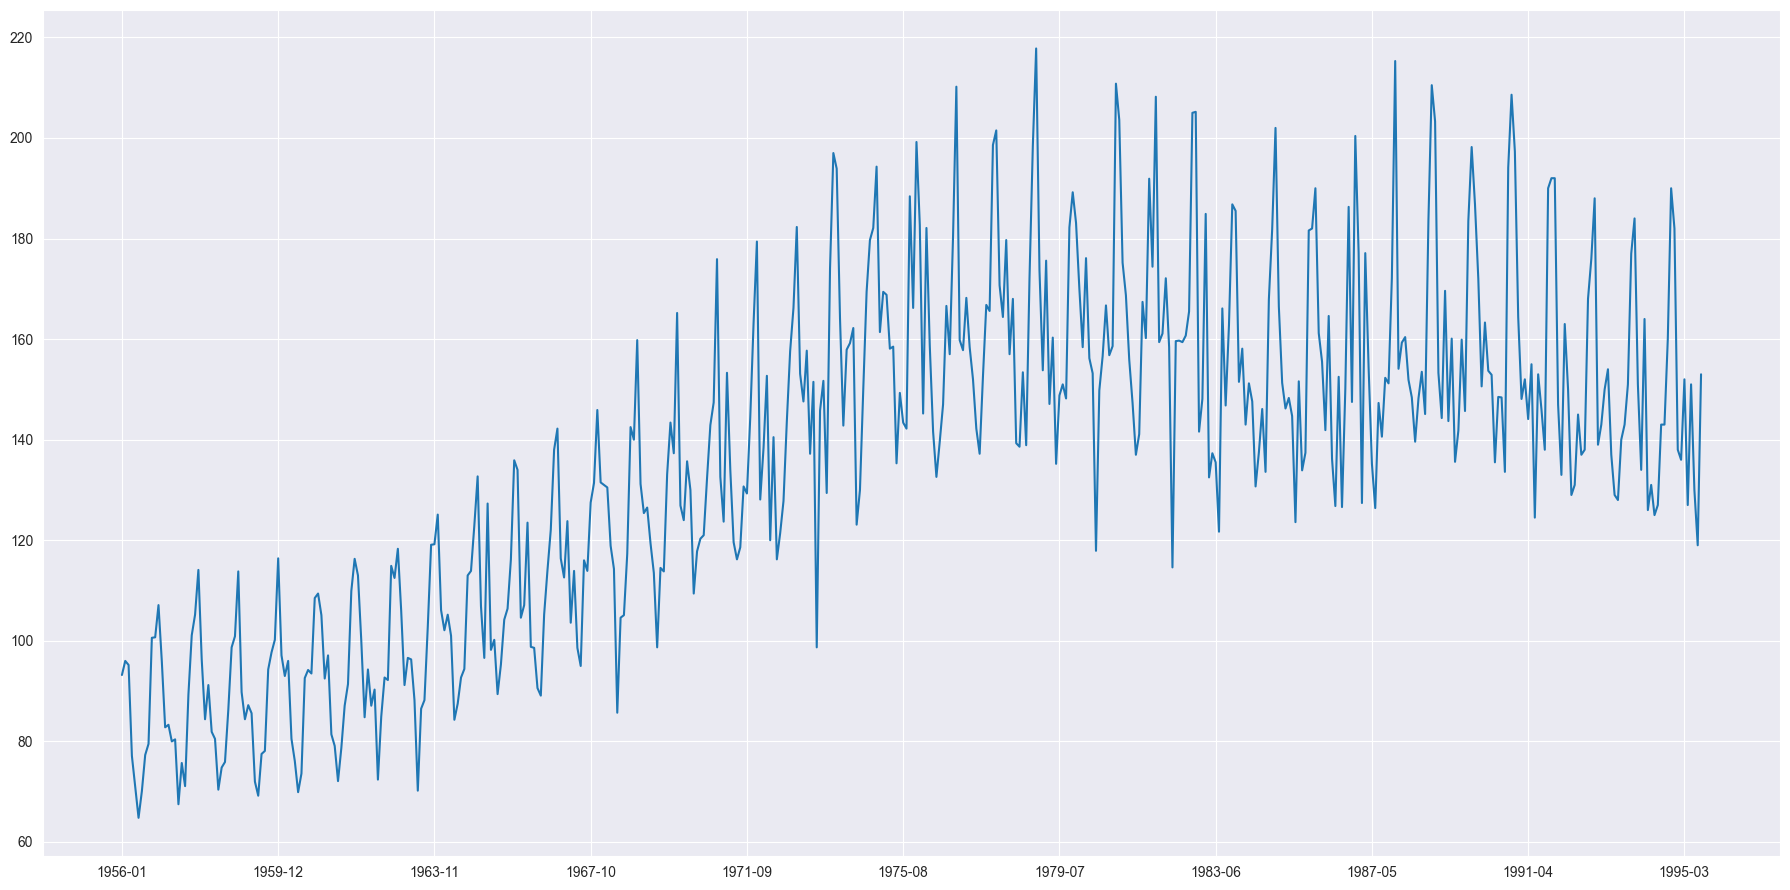

In [2]:
df = pd.read_csv("monthly-beer-production-in-austr.csv")
plt.figure(figsize=(18, 9))
plt.plot(df['Month'], df["Monthly beer production"])
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticks(ticks[::len(ticks) // 10])
plt.tight_layout()
plt.show()

In [3]:
df.describe()

,Monthly beer production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index.freq = 'MS'

<Axes: title={'center': 'Residual'}, xlabel='Month'>

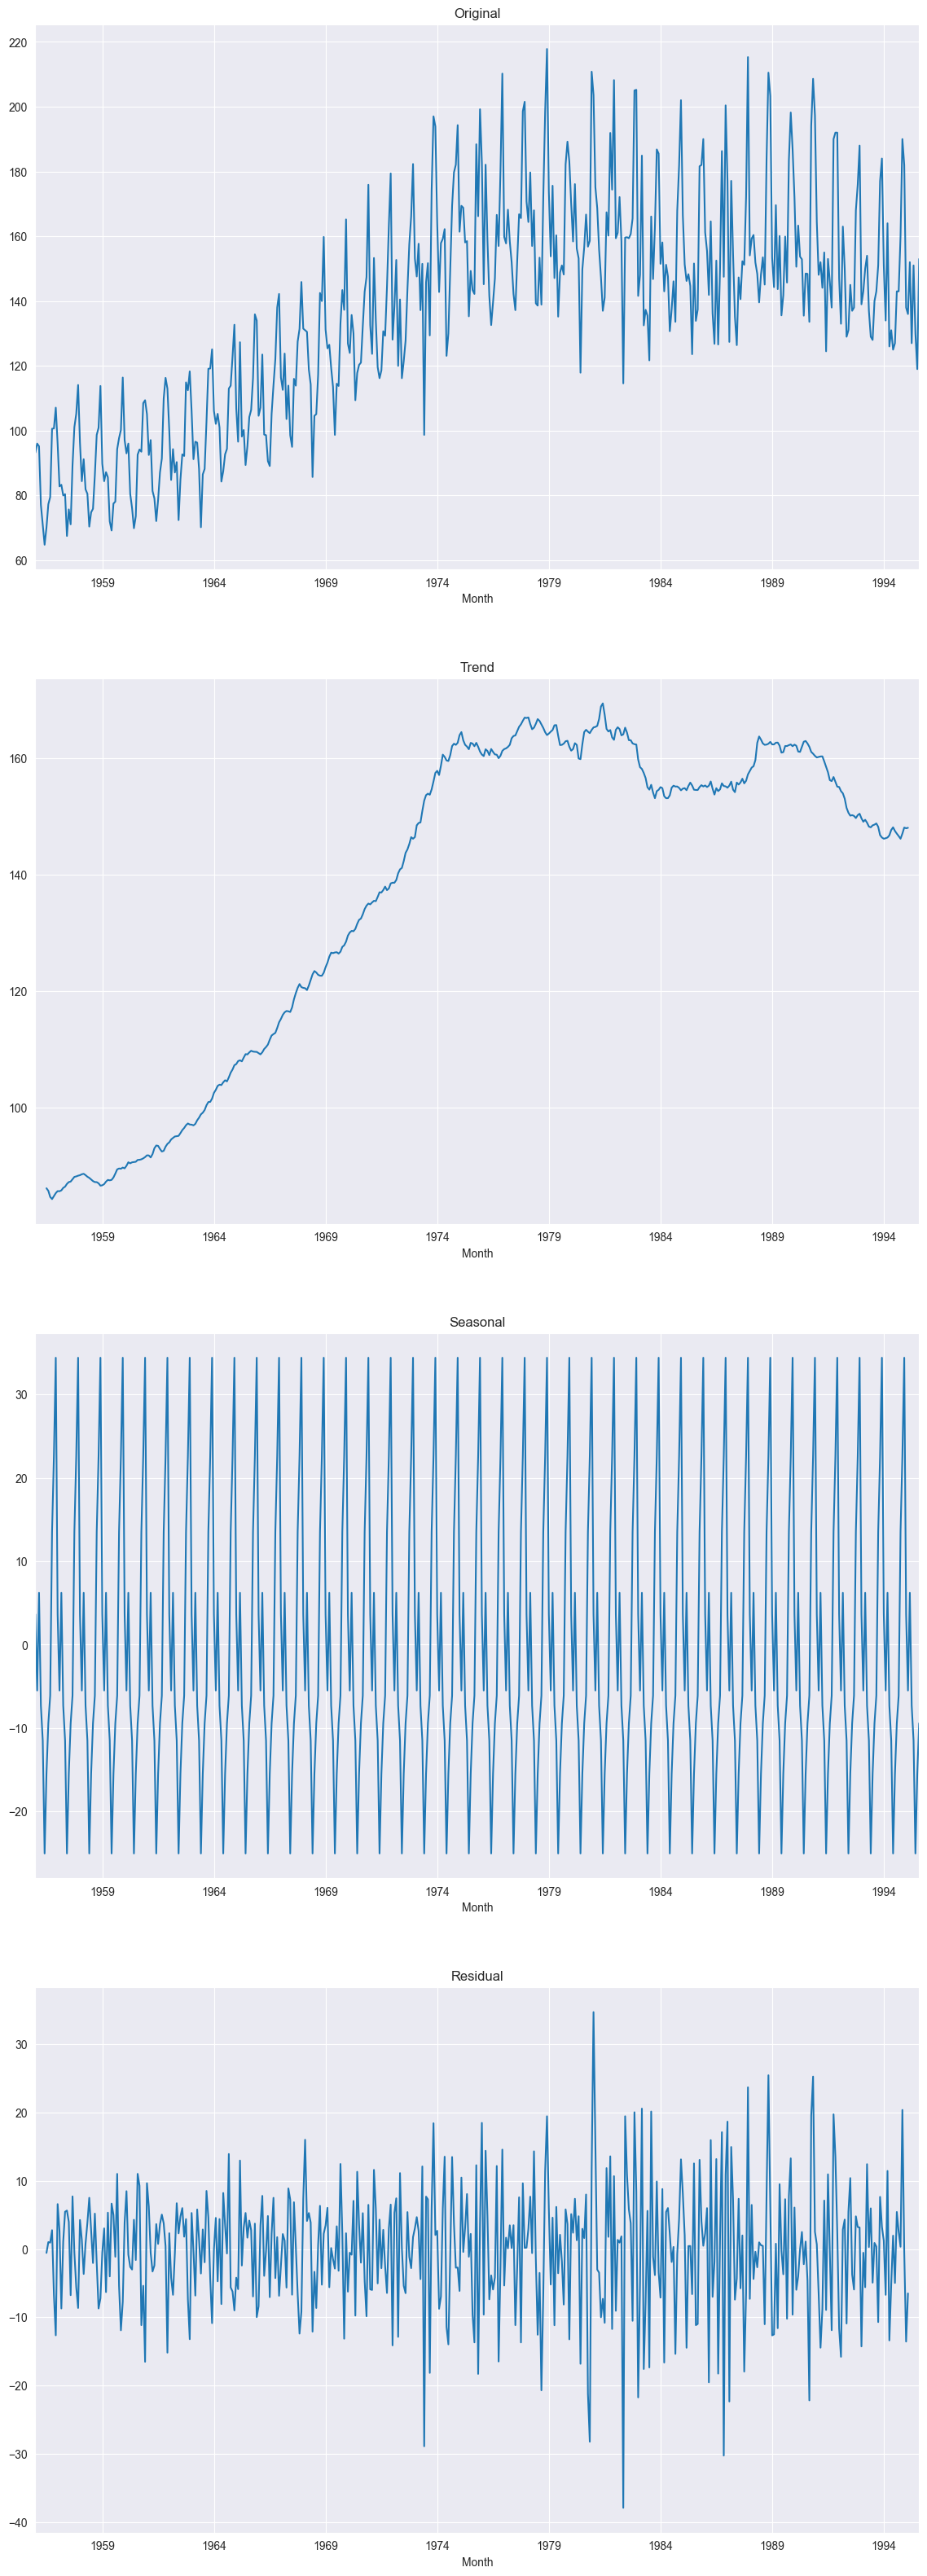

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))

decompose = seasonal_decompose(df["Monthly beer production"], model="add")
ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')
decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

In [7]:
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


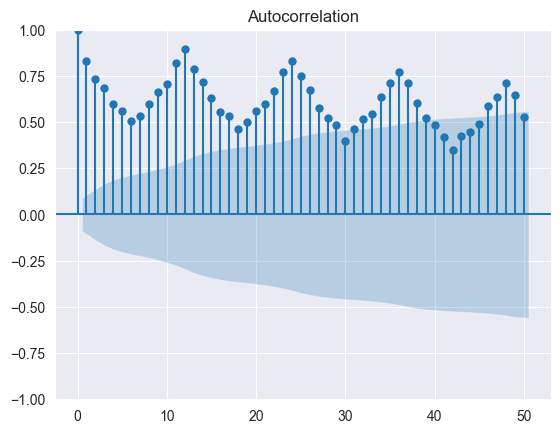

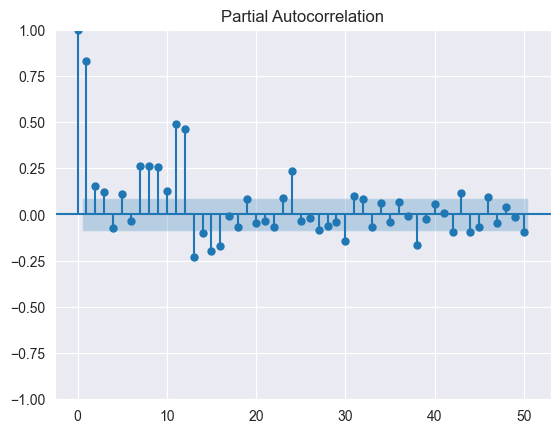

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["Monthly beer production"], lags=50)
plot_pacf(df["Monthly beer production"], lags=50)

plt.show()

Судя по всему, присутствует сезонность :)
Есть много локальных минимумов и максимумов. Даже можем предположить период - 12 месяцев, так как каждые 12 месяцев снова получаем максимум.
Ну а лаг для авторегрессии самый лучший - 1.

<Axes: xlabel='Month'>

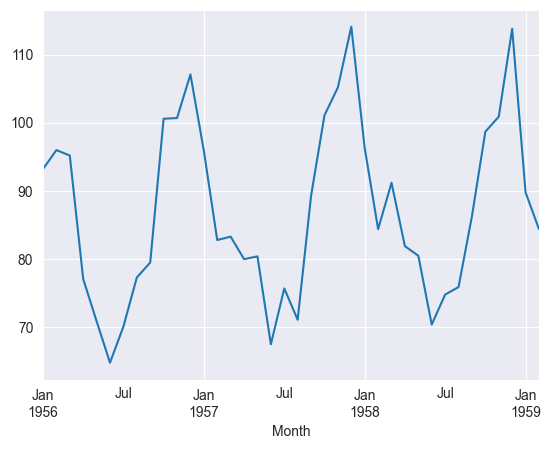

In [9]:
df['Monthly beer production'][:38].plot()

In [10]:
from statsmodels.tsa.stattools import adfuller

print(adfuller(df['Monthly beer production'])[1])


0.17762099829132627


p-value больше, чем 0.05. Значит нулевую гипотезу принимаем - ряд не стационарен. Но это только пока что

In [11]:
def difference(timeseries, lag):
    return [timeseries[i] - timeseries[i - lag] for i in range(lag, len(timeseries))]


diff_ts = df.iloc[1:].copy()
diff_ts["Monthly beer production"] = difference(np.log(df["Monthly beer production"]), 1)
#diff_ts["Monthly beer production"] = difference(df["Monthly beer production"], 1)

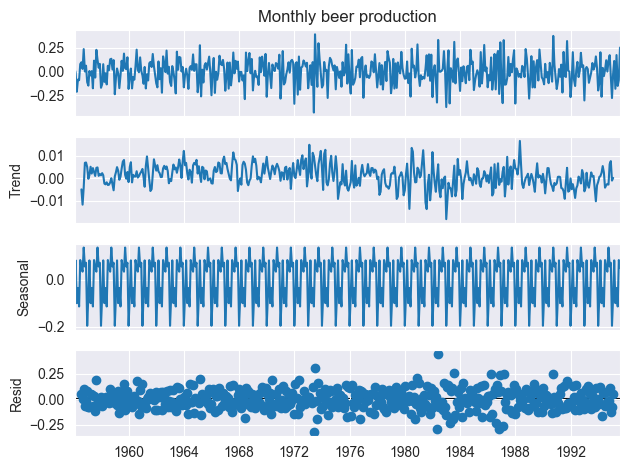

In [12]:
decompose = seasonal_decompose(diff_ts["Monthly beer production"], model="add")
decompose.plot()
plt.show()

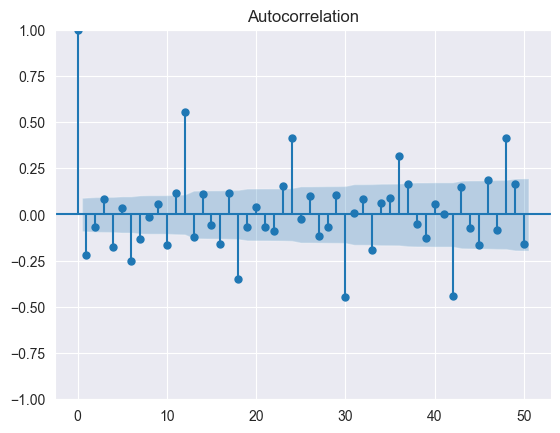

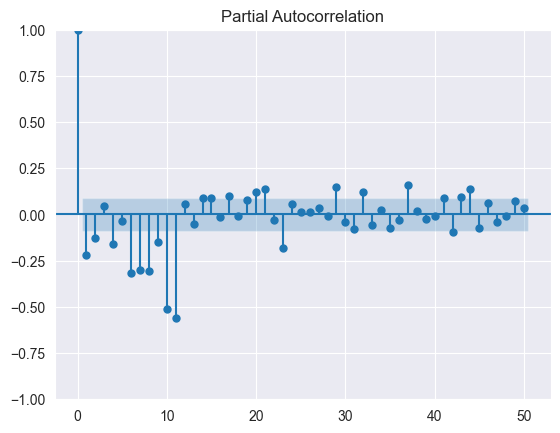

In [13]:
plot_acf(diff_ts["Monthly beer production"], lags=50)
plot_pacf(diff_ts["Monthly beer production"], lags=50)
plt.show()

Тренда теперь не вижу, осталась только сезонность

In [14]:

print(adfuller(diff_ts['Monthly beer production'])[1])


3.994274317730025e-05


0.019<0.05, а значит нулевая гипотеза не отвергнута в пользу альтернативной! Теперь вполне себе может быть стационарным

Подберём оптимальные параметры с помощью gridsearch:

In [15]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
p_s = d_s = q_s = range(0, 3)
seasonal_pdq = list(itertools.product(p_s, d_s, q_s, [12]))
print(seasonal_pdq)
train_size = int(len(df) * 0.8)
train, test = df['Monthly beer production'][:train_size], df['Monthly beer production'][train_size:]

best_aic = float('inf')
best_bic = float('inf')
best_hqic = float('inf')
best_mse = float('inf')
best_params = None
best_seasonal_params = None

for param in tqdm(pdq, total=len(pdq), desc="Grid Search Progress"):
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            test_preds = results.predict(start=train_size, end=len(df) - 1, dynamic=True)
            mse = mean_squared_error(test, test_preds)

            # Вывод метрик после обучения каждой модели
            print(
                f"ARIMA{param}x{param_seasonal} - MSE on test: {mse:.2f} AIC:{results.aic:.2f}, BIC:{results.bic:.2f}, HQIC:{results.hqic:.2f}")

            if best_mse > mse:
                best_mse = mse
                best_aic = results.aic
                best_bic = results.bic
                best_hqic = results.hqic
                best_params = param
                best_seasonal_params = param_seasonal
        except Exception as e:
            print(str(e))
            continue

print(
    f"Лучшие параметры: ARIMA{best_params}x{best_seasonal_params} - MSE on test: {best_mse:.2f} AIC:{best_aic:.2f}, BIC:{best_bic:.2f}, HQIC:{best_hqic:.2f}")

Mean Squared Error for the best model: 436.5400064534791
AIC: 1470.0881466040958
BIC: 1490.2276642521279
HQIC: 1478.2280692016436


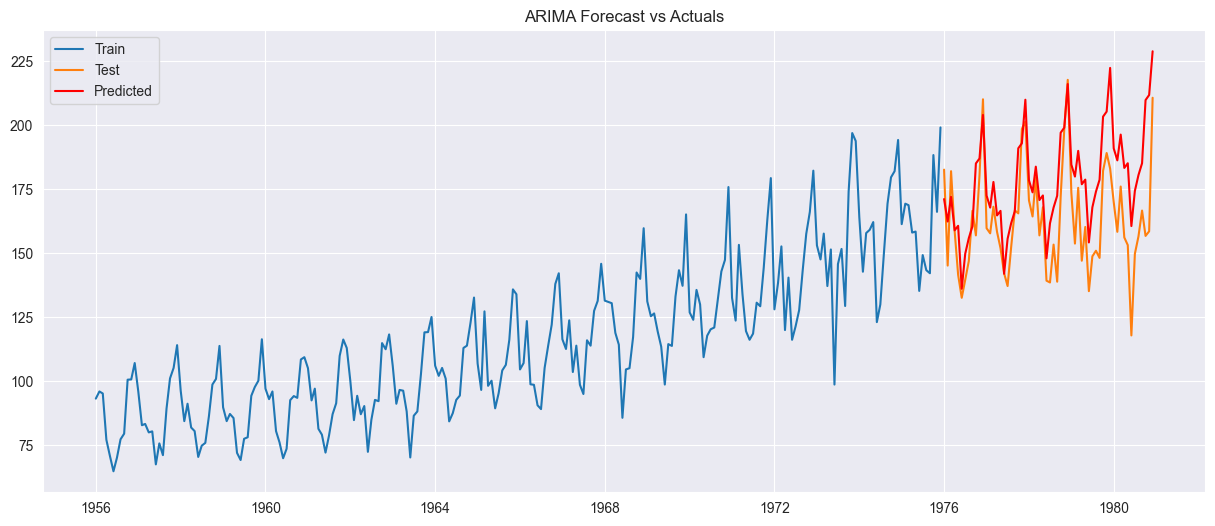

In [16]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# гиперпараметры получил из gridsearch
p, d, q, P, D, Q, s = 1, 0, 3, 0, 1, 1, 12
ts = df['Monthly beer production'][:300]
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]
best_model = SARIMAX(train,
                     order=(p, d, q),
                     seasonal_order=(P, D, Q, s),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results_best = best_model.fit()

start = len(train)
end = start + len(test) - 1
predictions = results_best.predict(start=start, end=end, dynamic=True)

mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error for the best model: {mse}")
print('AIC:', results_best.aic)
print('BIC:', results_best.bic)
print('HQIC:', results_best.hqic)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

Написал свою реализацию, теперь давайте сравним модель из библиотеки statmodels и мою шнягу

In [17]:
from sarima import SARIMA

my_model = SARIMA(ts, p, d, q, P, D, Q, s)
my_forecast = my_model.predict_in_sample(start, end)
my_mse = mean_squared_error(ts[start:end + 1], my_forecast)
print("MSE:", my_mse)
print('AIC:', my_model.aic)
print('BIC:', my_model.bic)
print('HQIC:', my_model.hqic)


MSE: 308.51600318523776
AIC: 893.1006522838155
BIC: 907.7610642193703
HQIC: 898.8351453338208


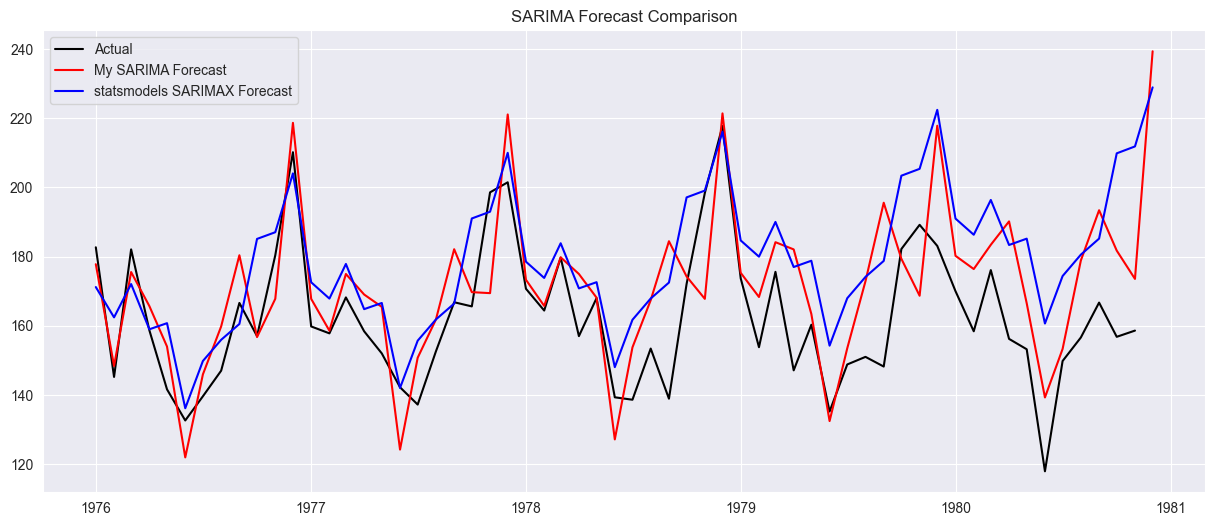

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(ts.index[start:end], ts[start:end], label='Actual', color='black')
plt.plot(ts.index[start:end + 1], my_forecast, label='My SARIMA Forecast', color='red')
plt.plot(ts.index[start:end + 1], predictions, label='statsmodels SARIMAX Forecast', color='blue')
plt.legend(loc='best')
plt.title('SARIMA Forecast Comparison')
plt.show()

## Итоги. Метрики.

In [21]:
from sklearn.metrics import mean_absolute_percentage_error

my_sarima_mape = mean_absolute_percentage_error(ts[start:end + 1], my_forecast)
sarimax_mape = mean_absolute_percentage_error(ts[start:end + 1], predictions)

print("Метрики для SARIMA, построенной с нуля:")
print("MSE:", my_mse)
print("MAPE:", my_sarima_mape)
print('AIC:', my_model.aic)
print('BIC:', my_model.bic)
print('HQIC:', my_model.hqic)

print("")

print("Метрики для SARIMAX, из библиотеки statmodels:")
print("MSE:", results_best.mse)
print('MAPE:', sarimax_mape)
print('AIC:', results_best.aic)
print('BIC:', results_best.bic)
print('HQIC:', results_best.hqic)

Метрики для SARIMA, построенной с нуля:
MSE: 308.51600318523776
MAPE: 0.08527777055073525
AIC: 893.1006522838155
BIC: 907.7610642193703
HQIC: 898.8351453338208

Метрики для SARIMAX, из библиотеки statmodels:
MSE: 147.5478665808376
MAPE: 0.10950676265464468
AIC: 1470.0881466040958
BIC: 1490.2276642521279
HQIC: 1478.2280692016436


#### Как можно видеть по всевозможным метрикам, собственноручно написанная модель работает вполне себе неплохо. Лично я доволен результатами проделанной работы.